Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1517/1517 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 3.9392 - mean_squared_error: 3.9392 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 2/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 3/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 4/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 6.1146e-04 - val_mean_squared_error: 6.1146e-04
Epoch 5/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 6.4965e-04 - val_mean_squared_error: 6.4965e-04
Epoch 6/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 7/10
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0020 - mean_squared_err

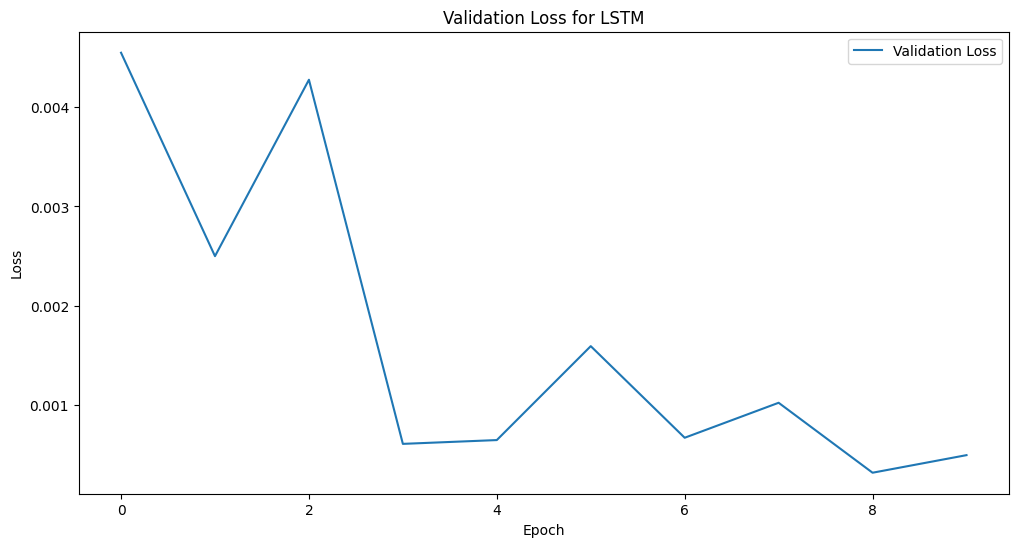

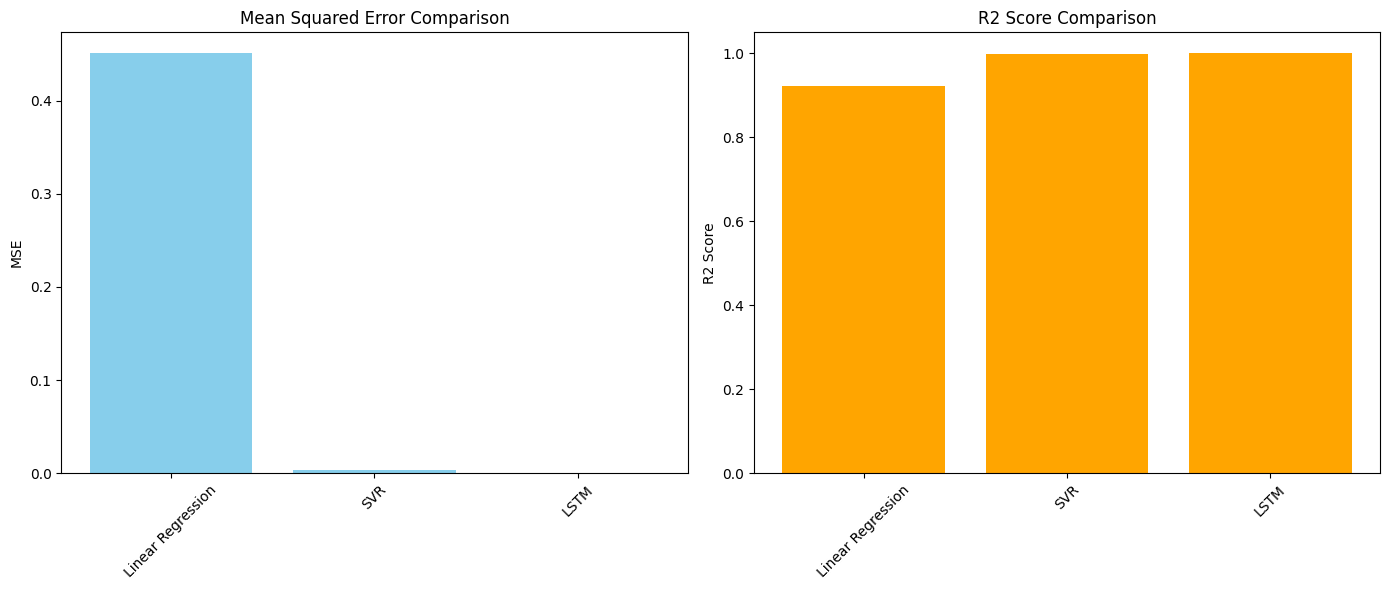

Model Performance:
Linear Regression: MSE = 0.4509, R2 = 0.9228
SVR: MSE = 0.0032, R2 = 0.9995
LSTM: MSE = 0.0005, R2 = 0.9999
Charging profiles saved to /content/drive/My Drive/Course Fall 24/Intro to ML/Project/Linear Regression_charging_profiles.csv
Charging profiles for Linear Regression saved to /content/drive/My Drive/Course Fall 24/Intro to ML/Project/Linear Regression_charging_profiles.csv
Charging profiles saved to /content/drive/My Drive/Course Fall 24/Intro to ML/Project/SVR_charging_profiles.csv
Charging profiles for SVR saved to /content/drive/My Drive/Course Fall 24/Intro to ML/Project/SVR_charging_profiles.csv
Charging profiles saved to /content/drive/My Drive/Course Fall 24/Intro to ML/Project/LSTM_charging_profiles.csv
Charging profiles for LSTM saved to /content/drive/My Drive/Course Fall 24/Intro to ML/Project/LSTM_charging_profiles.csv


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from google.colab import drive

# Load and preprocess data
def preprocess_data(hh_data, veh_data, trip_data):
    # Merge datasets
    ev_data = pd.merge(
        veh_data[veh_data['VEHFUEL'] == 1],  # Assuming 1 represents EVs
        trip_data[['HOUSEID', 'TRPMILES', 'ENDTIME']],
        on='HOUSEID'
    )

    # Engineering features
    ev_data['battery_capacity'] = np.random.uniform(40, 100, len(ev_data))  # kWh
    ev_data['initial_soc'] = np.random.uniform(0.1, 0.9, len(ev_data))  # %
    ev_data['charging_power'] = np.random.choice([7, 11], size=len(ev_data))  # kW
    ev_data['distance'] = ev_data['TRPMILES'] * 1.60934  # Convert miles to km
    ev_data['arrival_time'] = ev_data['ENDTIME']  # Use ENDTIME column as arrival time

    # Target variables
    ev_data['energy_required'] = ev_data['battery_capacity'] * (1 - ev_data['initial_soc'])
    ev_data['charging_time'] = ev_data['energy_required'] / ev_data['charging_power']
    ev_data['charge_start_time'] = ev_data['arrival_time']

    return ev_data

# LSTM Model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
    return model

# Train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test):
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)

    # SVR
    svr = SVR(kernel='rbf', C=100, epsilon=0.1)
    svr.fit(X_train, y_train)
    y_pred_svr = svr.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)

    # LSTM
    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    lstm = create_lstm_model((X_train.shape[1], 1))
    history = lstm.fit(
        X_train_lstm, y_train,
        validation_data=(X_test_lstm, y_test),
        epochs=10, batch_size=32, verbose=1
    )
    y_pred_lstm = lstm.predict(X_test_lstm).flatten()  # Flatten to 1D array
    mse_lstm = mean_squared_error(y_test, y_pred_lstm)
    r2_lstm = r2_score(y_test, y_pred_lstm)

    # Plot Validation Loss and Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Validation Loss for LSTM')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Return model results and predictions
    return {
        'Linear Regression': (mse_lr, r2_lr, y_pred_lr),
        'SVR': (mse_svr, r2_svr, y_pred_svr),
        'LSTM': (mse_lstm, r2_lstm, y_pred_lstm)
    }

# Generate EV charging profiles
def generate_charging_profiles(ev_data, output_file='ev_charging_profiles.csv'):
    #print("Function `generate_charging_profiles` started.")
    #print(f"Processing {len(ev_data)} rows from ev_data...")

    charging_profiles = []

    for index, row in ev_data.head(100).iterrows():
        profile = [0] * 24  # Initialize hourly profile with zeros

        # Convert HHMM to decimal hours
        raw_start_time = row['charge_start_time']  # Assuming it's in HHMM format
        start_hour = raw_start_time // 100  # Extract the hour part
        start_minute = raw_start_time % 100  # Extract the minute part
        start_time_decimal = start_hour + (start_minute / 60)  # Convert to decimal hours

        # Round up start time and charging time
        start_hour_rounded = int(np.ceil(start_time_decimal))  # Round up to the next hour
        charging_duration = int(np.ceil(row['predicted_charging_time']))  # Use predicted charging time

        # Calculate end hour
        end_hour_rounded = start_hour_rounded + charging_duration

        # Debug: Print times for verification
        #print(f"Vehicle ID: {index}, Start Hour: {start_hour_rounded}, Duration: {charging_duration}, "
              #f"End Hour: {end_hour_rounded}, Charging Power: {row['charging_power']}")

        # Assign charging power for each hour
        for hour in range(start_hour_rounded, end_hour_rounded):
            if 0 <= hour < 24:  # Ensure within valid range
                profile[hour] = row['charging_power']

        charging_profiles.append(profile)

    # Create a DataFrame for the profiles
    profile_df = pd.DataFrame(charging_profiles, columns=[f'Hour_{i}' for i in range(24)])
    profile_df.insert(0, 'Vehicle_ID', ev_data.head(100).index)  # Add Vehicle_ID as the first column

    # Save to CSV
    profile_df.to_csv(output_file, index=False)
    print(f"Charging profiles saved to {output_file}")

# Main execution
def main():
    # Mount Google Drive
    drive.mount('/content/drive')
    # Load datasets
    hh_data = pd.read_csv("/content/drive/My Drive/Course Fall 24/Intro to ML/Project/Data CSVs/hhv2pub.csv")
    veh_data = pd.read_csv("/content/drive/My Drive/Course Fall 24/Intro to ML/Project/Data CSVs/vehv2pub.csv")
    trip_data = pd.read_csv("/content/drive/My Drive/Course Fall 24/Intro to ML/Project/Data CSVs/tripv2pub.csv")

    # Preprocess data
    ev_data = preprocess_data(hh_data, veh_data, trip_data)

    # Prepare features and targets
    X = ev_data[['battery_capacity', 'initial_soc', 'charging_power', 'distance']].values
    y = ev_data['charging_time'].values

    # Split data
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
        X, y, ev_data.index, test_size=0.2, random_state=42
    )

    # Scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    results = train_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

    # Visualization of comparison
    model_names = list(results.keys())
    mse_values = [results[model][0] for model in model_names]
    r2_values = [results[model][1] for model in model_names]

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.bar(model_names, mse_values, color='skyblue')
    plt.title('Mean Squared Error Comparison')
    plt.ylabel('MSE')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.bar(model_names, r2_values, color='orange')
    plt.title('R2 Score Comparison')
    plt.ylabel('R2 Score')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print("Model Performance:")
    for model, metrics in results.items():
        print(f"{model}: MSE = {metrics[0]:.4f}, R2 = {metrics[1]:.4f}")

    # Generate charging profiles for each model's predictions
    model_predictions = {
        'Linear Regression': results['Linear Regression'][2],
        'SVR': results['SVR'][2],
        'LSTM': results['LSTM'][2]
    }

    for model_name, predictions in model_predictions.items():
        # Combine predictions with the original index
        full_predictions = pd.Series(index=ev_data.index, dtype=float)
        full_predictions.iloc[test_idx] = predictions  # Assign test predictions to test indices

        # Replace NaN values with the mean of the predictions
        full_predictions.fillna(ev_data['charging_time'].mean(), inplace=True)

        # Update ev_data with predicted charging times
        ev_data['predicted_charging_time'] = full_predictions
        output_file_path = f'/content/drive/My Drive/Course Fall 24/Intro to ML/Project/{model_name}_charging_profiles.csv'
        generate_charging_profiles(ev_data, output_file=output_file_path)
        print(f"Charging profiles for {model_name} saved to {output_file_path}")



if __name__ == "__main__":
    main()


Loading /content/drive/My Drive/Course Fall 24/Intro to ML/Project/Linear Regression_charging_profiles.csv
Loading /content/drive/My Drive/Course Fall 24/Intro to ML/Project/SVR_charging_profiles.csv
Loading /content/drive/My Drive/Course Fall 24/Intro to ML/Project/LSTM_charging_profiles.csv
Differences saved to /content/drive/My Drive/Course Fall 24/Intro to ML/Project/model_comparison.csv


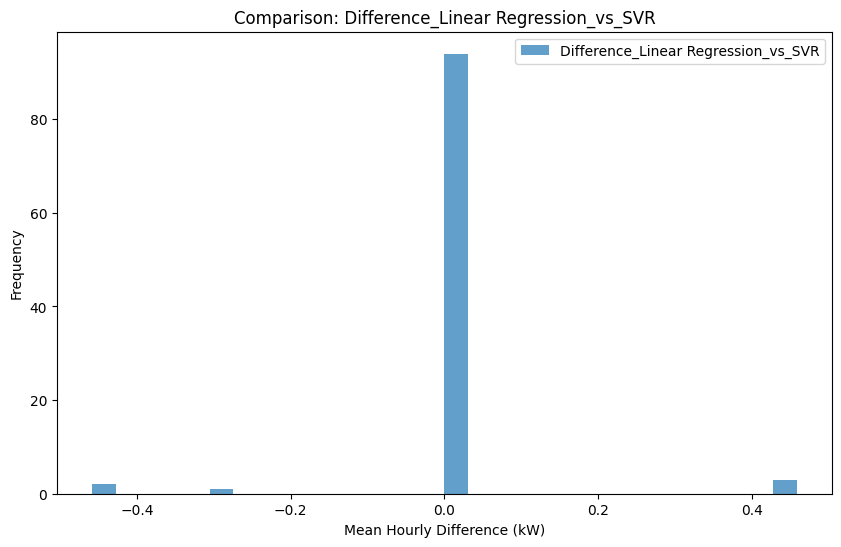

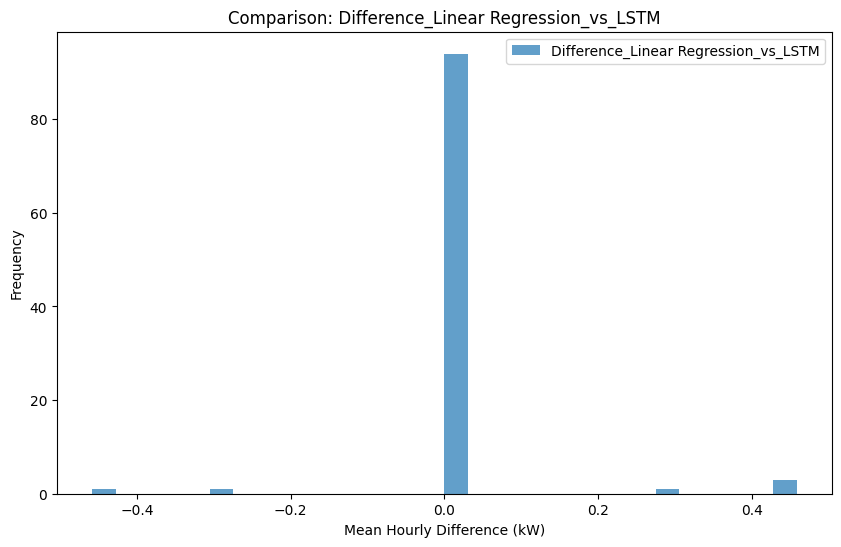

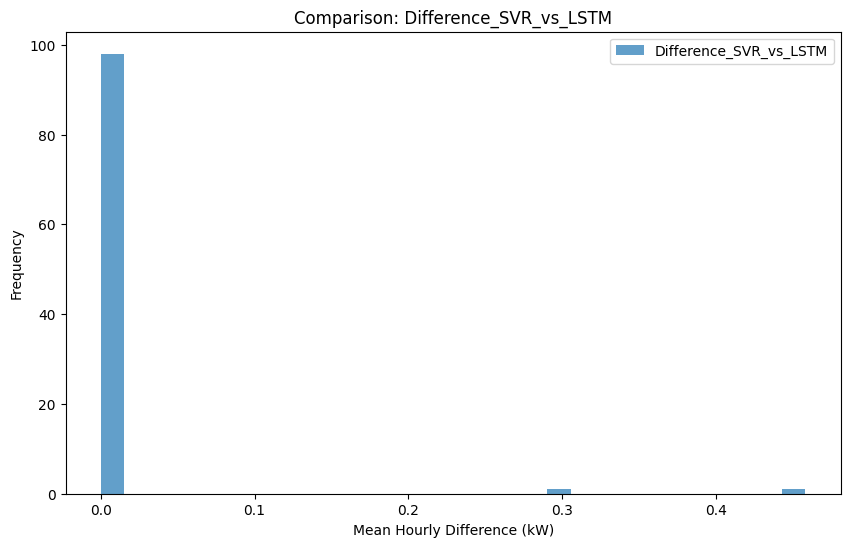

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def compare_model_predictions(base_path, models, output_file='model_comparison.csv'):
    model_data = {}

    # Load CSV files for each model
    for model in models:
        file_path = os.path.join(base_path, f"{model.replace(' ', ' ')}_charging_profiles.csv")
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            return
        print(f"Loading {file_path}")
        model_data[model] = pd.read_csv(file_path)

    # Ensure all models have the same structure
    vehicle_ids = model_data[models[0]]['Vehicle_ID']
    hourly_columns = [f'Hour_{i}' for i in range(24)]

    # Create a DataFrame to store differences
    differences = pd.DataFrame({'Vehicle_ID': vehicle_ids})

    # Calculate pairwise differences
    for i, model_1 in enumerate(models):
        for model_2 in models[i + 1:]:
            diff_name = f"Difference_{model_1}_vs_{model_2}"
            differences[diff_name] = (
                model_data[model_1][hourly_columns].values -
                model_data[model_2][hourly_columns].values
            ).mean(axis=1)  # Mean difference across all hours

    # Save the differences to a CSV
    output_file_path = os.path.join(base_path, output_file)
    differences.to_csv(output_file_path, index=False)
    print(f"Differences saved to {output_file_path}")

    # Visualization
    for diff_col in differences.columns[1:]:
        plt.figure(figsize=(10, 6))
        plt.hist(differences[diff_col], bins=30, alpha=0.7, label=diff_col)
        plt.xlabel('Mean Hourly Difference (kW)')
        plt.ylabel('Frequency')
        plt.title(f'Comparison: {diff_col}')
        plt.legend()
        plt.show()

# Call the function
base_path = "/content/drive/My Drive/Course Fall 24/Intro to ML/Project"
models = ['Linear Regression', 'SVR', 'LSTM']
compare_model_predictions(base_path, models)
